# Test of the new Reflected Bkg with Gammapy (run pipeline)

In this tutorial we will learn how to perform a 1d spectral analysis.

We will use a "pipeline" or "workflow" class to run a standard analysis. If you're interested in implementation detail of the analysis in order to create a custom analysis class, you should read ([spectrum_analysis.ipynb](spectrum_analysis.ipynb)) that executes the analysis using lower-level classes and methods in Gammapy. 

In this tutorial we will use the folling Gammapy classes:

- [gammapy.data.DataStore](https://docs.gammapy.org/dev/api/gammapy.data.DataStore.html) to load the data to 
- [gammapy.scripts.SpectrumAnalysisIACT](https://docs.gammapy.org/dev/api/gammapy.scripts.SpectrumAnalysisIACT.html) to run the analysis

We use 4 Crab observations from H.E.S.S. for testing.

## Setup

As usual, we'll start with some setup for the notebook, and import the functionality we need.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import PixCoord, CircleSkyRegion, CircleAnnulusSkyRegion, EllipseSkyRegion, EllipseAnnulusSkyRegion, RectangleSkyRegion, RectangleAnnulusSkyRegion, PolygonSkyRegion

from gammapy.data import DataStore
from gammapy.catalog import SourceCatalogGammaCat
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator, ReflectedRegionsBackgroundEstimator_BK
from gammapy.stats import significance_on_off

## Select data

First, we select and load some H.E.S.S. data (simulated events for now). In real life you would do something fancy here, or just use the list of observations someone send you (and hope they have done something fancy before). We'll just use the standard gammapy 4 crab runs.

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
observations = data_store.get_observations(obs_ids)
print(obs_ids)

[23523 23526 23559 23592]


## Configure the analysis

Now we'll define the input for the spectrum analysis. It will be done the python way, i.e. by creating a config dict containing python objects. We plan to add also the convenience to configure the analysis using a plain text config file.

In [3]:
crab_pos = SkyCoord.from_name("crab")
print(crab_pos)
on_region = CircleSkyRegion(crab_pos, 0.15 * u.deg)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>


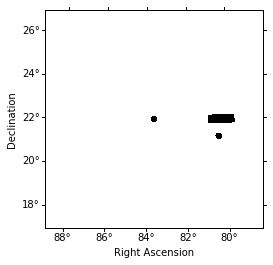

In [4]:
exclusion_mask = Map.create(skydir=crab_pos, width=(10, 10), binsz=0.02)

gammacat = SourceCatalogGammaCat("$GAMMAPY_DATA/catalogs/gammacat/gammacat.fits.gz")

regions = []
for source in gammacat:
    if not exclusion_mask.geom.contains(source.position):
        continue
    region = CircleSkyRegion(source.position, 0.15 * u.deg)
    regions.append(region)

region = RectangleSkyRegion(center=SkyCoord(80.3,22.0,unit="deg"),
                                    width=1.2 * u.deg, height=0.4 * u.deg,
                                    angle=0 * u.deg)
regions.append(region)

exclusion_mask.data = exclusion_mask.geom.region_mask(regions, inside=False)
exclusion_mask.plot();

In [5]:
config = dict(
    outdir=".",
    background=dict(
        on_region=on_region,
        exclusion_mask=exclusion_mask,
        min_distance=0.1 * u.rad,
    )
)

## Test different region types

CoG=<SkyCoord (ICRS): (ra, dec) in deg
    (83.49335254, 21.51444058)> 
Radius=0.7003274046925362 deg


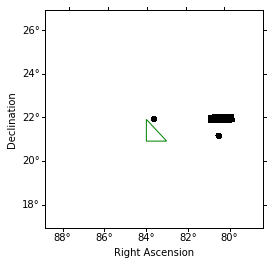

In [6]:
polygon_sky = PolygonSkyRegion(vertices=SkyCoord([83, 84, 84], [21, 21, 22], unit='deg', frame='icrs'))
exclusion_mask.plot();
polygon_pix = polygon_sky.to_pixel(exclusion_mask.geom.wcs)
polygon_pix.plot();

ixmin=polygon_pix.bounding_box.ixmin
ixmax=polygon_pix.bounding_box.ixmax
iymin=polygon_pix.bounding_box.iymin
iymax=polygon_pix.bounding_box.iymax
CoG = PixCoord((ixmin+ixmax)/2., (iymin+iymax)/2.).to_sky(exclusion_mask.geom.wcs)
Radius = CoG.separation(PixCoord(ixmin,iymin).to_sky(exclusion_mask.geom.wcs))
print("CoG={0} \nRadius={1}".format(CoG, Radius))

ICRS frame
BoundingBox(ixmin=132, ixmax=333, iymin=99, iymax=300)
CoG=<SkyCoord (ICRS): (ra, dec) in deg
    (83.99725187, 21.01409498)>
Radius=2.841626076086742 deg


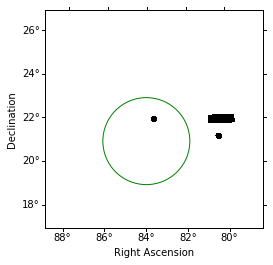

In [7]:
center = SkyCoord(84, 21, unit='deg')
radius = Angle(2, 'deg')
circle = CircleSkyRegion(center, radius)
if 'l' in circle.center.representation_component_names:
    print("Galactic frame")
else:
    print("ICRS frame")
exclusion_mask.plot();
circle_pix = circle.to_pixel(exclusion_mask.geom.wcs)
circle_pix.plot();

print(circle_pix.bounding_box)
ixmin=circle_pix.bounding_box.ixmin
ixmax=circle_pix.bounding_box.ixmax
iymin=circle_pix.bounding_box.iymin
iymax=circle_pix.bounding_box.iymax
CoG = PixCoord((ixmin+ixmax)/2., (iymin+iymax)/2.).to_sky(exclusion_mask.geom.wcs)
Radius = CoG.separation(PixCoord(ixmin,iymin).to_sky(exclusion_mask.geom.wcs))
print("CoG={0}\nRadius={1}".format(CoG, Radius))

BoundingBox(ixmin=146, ixmax=320, iymin=119, iymax=280)
CoG=<SkyCoord (ICRS): (ra, dec) in deg
    (83.98654107, 21.01411846)>
Radius=2.3699148510581876 deg


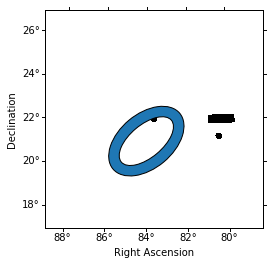

In [8]:
ellipse_annulus_sky = EllipseAnnulusSkyRegion(center=center,
                                               inner_width=1.5 * u.deg,
                                               outer_width=2.5 * u.deg,
                                               inner_height=3 * u.deg,
                                               outer_height=4 * u.deg,
                                               angle=130 * u.deg)
exclusion_mask.plot();
ellipse_annulus_pix = ellipse_annulus_sky.to_pixel(exclusion_mask.geom.wcs)
ellipse_annulus_pix.plot();

print(ellipse_annulus_pix.bounding_box)
ixmin=ellipse_annulus_pix.bounding_box.ixmin
ixmax=ellipse_annulus_pix.bounding_box.ixmax
iymin=ellipse_annulus_pix.bounding_box.iymin
iymax=ellipse_annulus_pix.bounding_box.iymax
CoG = PixCoord((ixmin+ixmax)/2., (iymin+iymax)/2.).to_sky(exclusion_mask.geom.wcs)
Radius = CoG.separation(PixCoord(ixmin,iymin).to_sky(exclusion_mask.geom.wcs))
print("CoG={0}\nRadius={1}".format(CoG, Radius))

BoundingBox(ixmin=124, ixmax=342, iymin=96, iymax=302)
CoG=<SkyCoord (ICRS): (ra, dec) in deg
    (83.9865163, 21.00411848)>
Radius=2.998243478870509 deg


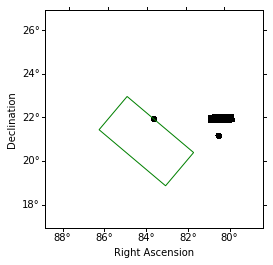

In [9]:
rectangle_sky = RectangleSkyRegion(center=center,
                                    width=2. * u.deg, height=4. * u.deg,
                                    angle=50 * u.deg)
exclusion_mask.plot();
rectangle_pix = rectangle_sky.to_pixel(exclusion_mask.geom.wcs)
rectangle_pix.plot();

print(rectangle_pix.bounding_box)
ixmin=rectangle_pix.bounding_box.ixmin
ixmax=rectangle_pix.bounding_box.ixmax
iymin=rectangle_pix.bounding_box.iymin
iymax=rectangle_pix.bounding_box.iymax
CoG = PixCoord((ixmin+ixmax)/2., (iymin+iymax)/2.).to_sky(exclusion_mask.geom.wcs)
Radius = CoG.separation(PixCoord(ixmin,iymin).to_sky(exclusion_mask.geom.wcs))
print("CoG={0}\nRadius={1}".format(CoG, Radius))

## Configuration of the Reflected Bg Makers


In [10]:
background_estimator = ReflectedRegionsBackgroundEstimator(
            observations=observations, **config["background"]
        )

In [11]:
# rectangle_sky = RectangleSkyRegion(center=crab_pos.transform_to('galactic'),
#                                     width=0.5 * u.deg, height=0.4 * u.deg,
#                                     angle=0 * u.deg)
# rectangle_sky = RectangleSkyRegion(center=crab_pos,
#                                     width=0.5 * u.deg, height=0.4 * u.deg,
#                                     angle=0 * u.deg)
# config = dict(
#     outdir=".",
#     background=dict(
#         on_region=rectangle_sky,
#         exclusion_mask=exclusion_mask,
#         min_distance=0.1 * u.rad,
#     )
# )

config = dict(
    outdir=".",
    background=dict(
        on_region = CircleSkyRegion(crab_pos.transform_to('galactic'), 0.15 * u.deg),
        exclusion_mask=exclusion_mask,
        min_distance=0.1 * u.rad,
    )
)
background_bk_estimator = ReflectedRegionsBackgroundEstimator_BK(
            observations=observations, **config["background"]
        )

## Results from initial class

Let's look at the results, and also compare with a previously published Crab nebula spectrum for reference.

In [12]:
background_estimator.run()

/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


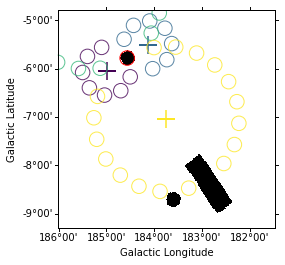

In [13]:
background_estimator.plot();

In [14]:
on_s = 0
off_s = 0
a_on_s = 0
a_off_s = 0
for obs_result in background_estimator.result:
    on_s += len(obs_result.on_events.table)
    off_s += len(obs_result.off_events.table)
    a_on_s += obs_result.a_on
    a_off_s += obs_result.a_off
    print(obs_result)
    print("\n")

alpha = a_on_s/a_off_s
excess = on_s - off_s*alpha
sigma = significance_on_off(on_s, off_s, alpha)
print("\n Total ON : {0} | Total OFF : {1} | Alpha : {2:.4f}".format(on_s, off_s, alpha))
print(" Total Excess : {0:.2f} | Sigma = {1:.2f}".format(excess, sigma))

BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.15 deg
 EventList info:
- Number of events: 255
- Median energy: 0.97 TeV
- OBS_ID = 23523
 off region
 [<CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (184.49445147, -6.17309691)>, radius=0.15000538537959704 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (184.69165367, -6.45982442)>, radius=0.15000192030559253 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.02935512, -6.54955664)>, radius=0.15000006265358506 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.34431034, -6.39890795)>, radius=0.15000297126018794 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.48434371, -6.0807053)>, radius=0.1500057008221304 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.38216315, -5.74858995)>, radius=0.15000361453508604 deg)>, <CircleS

## Results from the new class

In [15]:
background_bk_estimator.run()

Found 7 reflected regions for the Obs #23523
Found 7 reflected regions for the Obs #23526
Found 19 reflected regions for the Obs #23559
Found 18 reflected regions for the Obs #23592


/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in l

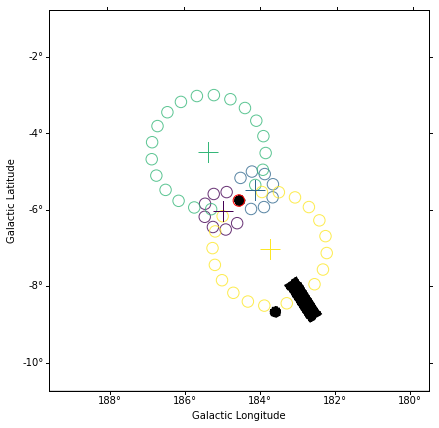

In [16]:
background_bk_estimator.plot();

In [17]:
on_s = 0
off_s = 0
a_on_s = 0
a_off_s = 0
for obs_result in background_bk_estimator.result:
    on_s += len(obs_result.on_events.table)
    off_s += len(obs_result.off_events.table)
    a_on_s += obs_result.a_on
    a_off_s += obs_result.a_off
    print(obs_result)
    print("\n")

alpha = a_on_s/a_off_s
excess = on_s - off_s*alpha
sigma = significance_on_off(on_s, off_s, alpha)
print("\n Total ON : {0} | Total OFF : {1} | Alpha : {2:.4f}".format(on_s, off_s, alpha))
print(" Total Excess : {0:.2f} | Sigma = {1:.2f}".format(excess, sigma))

BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: CircleSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    (184.55745788, -5.78435671)>
radius: 0.15 deg
 EventList info:
- Number of events: 7613
- Median energy: 0.953 TeV
- OBS_ID = 23523
 off region
 [<CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (184.87936521, -5.5622377)>, radius=0.1499961585618612 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.22072688, -5.61145877)>, radius=0.1499972038147529 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.44995267, -5.86802695)>, radius=0.1500008635117745 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.45898053, -6.21119666)>, radius=0.1500010604738155 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185.24319978, -6.47925175)>, radius=0.14999746832349906 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (184.90421446, -6.54568392)>, radius=0.14999606941445762 deg)>, <Ci

In [18]:
toto = CircleSkyRegion(crab_pos.transform_to('galactic'), 0.15 * u.deg)
print(background_bk_estimator.binsz)

0.01 deg
